In [2]:
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from random import randint
from gensim.models import Word2Vec
from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import accuracy_score
import scipy.sparse as sp
import torch
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
import time
import torch.optim as optim
from utils import load_cora, normalize_adjacency, sparse_to_torch_sparse
from models import GNN



# 2. Node embeddings

In [3]:
############## Task 1
# Simulates a random walk of length "walk_length" starting from node "node"
def random_walk(G, node, walk_length):

    ##################
    walk = [node]
    for i in range(walk_length-1):
        j = randint(0, G.degree(node)-1)
        node = list(G.neighbors(node))[j]
        walk.append(node)
    ##################
    walk = [str(node) for node in walk]
    return walk

In [4]:
############## Task 2
# Runs "num_walks" random walks from each node
def generate_walks(G, num_walks, walk_length):
    walks = []

    ##################
    for node in G.nodes():
        for i in range(num_walks):
            walks.append(random_walk(G,node,walk_length))
    permuted_walks = np.random.permutation(walks)
    ##################

    return permuted_walks.tolist()





In [5]:
# Simulates walks and uses the Skipgram model to learn node representations
def deepwalk(G, num_walks, walk_length, n_dim):
    print("Generating walks")
    walks = generate_walks(G, num_walks, walk_length)

    print("Training word2vec")
    model = Word2Vec(vector_size=n_dim, window=8, min_count=0, sg=1, workers=8, hs=1)
    model.build_vocab(walks)
    model.train(walks, total_examples=model.corpus_count, epochs=5)

    return model

In [7]:
# Loads the web graph
G = nx.read_weighted_edgelist('data/web_sample.edgelist', delimiter=' ', create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 12240
Number of edges: 18659


In [8]:
############## Task 3
# Extracts a set of random walks from the web graph and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20


##################
model = deepwalk(G, n_walks, walk_length, n_dim)
##################

Generating walks
Training word2vec


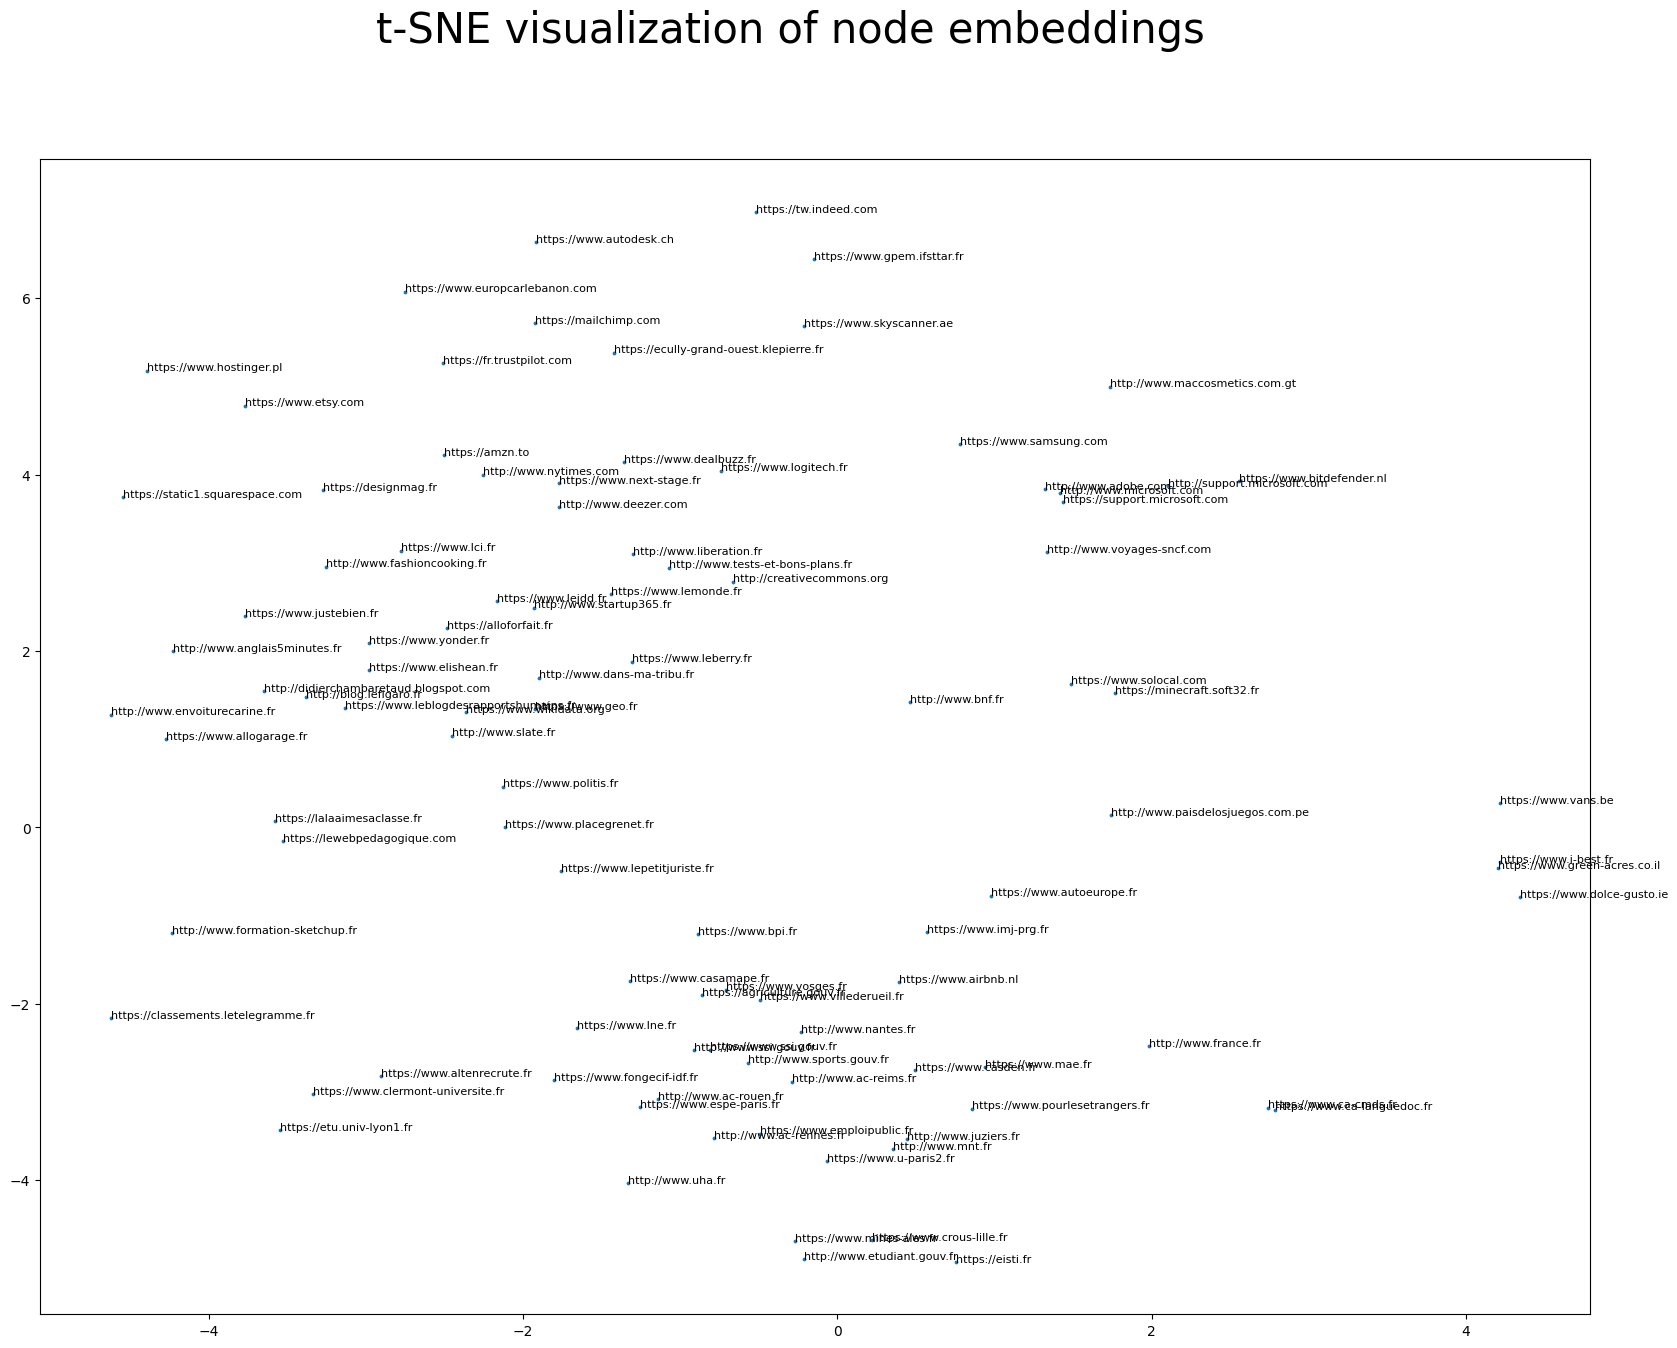

In [9]:
############## Task 4
# Visualizes the representations of the 100 nodes that appear most frequently in the generated walks
def visualize(model, n, dim):

    nodes = model.wv.index_to_key[:n] # your code here
    DeepWalk_embeddings = np.empty(shape=(n, dim))

    ##################
    DeepWalk_embeddings = model.wv[nodes]
    ##################


    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2)

    vecs_pca = my_pca.fit_transform(DeepWalk_embeddings)
    vecs_tsne = my_tsne.fit_transform(vecs_pca)

    fig, ax = plt.subplots()
    ax.scatter(vecs_tsne[:,0], vecs_tsne[:,1],s=3)
    for x, y, node in zip(vecs_tsne[:,0] , vecs_tsne[:,1], nodes):
        ax.annotate(node, xy=(x, y), size=8)
    fig.suptitle('t-SNE visualization of node embeddings',fontsize=30)
    fig.set_size_inches(20,15)
    plt.savefig('embeddings.pdf')
    plt.show()


visualize(model, 100, n_dim)


In [10]:

# Loads the karate network
G = nx.read_weighted_edgelist('data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)




Number of nodes: 34
Number of edges: 78


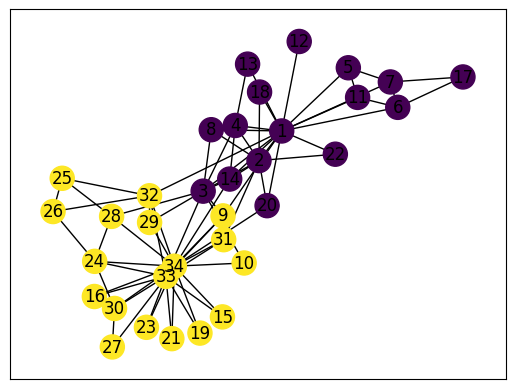

In [11]:
############## Task 5
# Visualizes the karate network

##################
nx.draw_networkx(G, node_color=[idx_to_class_label[node] for node in G.nodes()])
##################

In [12]:
############## Task 6
# Extracts a set of random walks from the karate network and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20
model = deepwalk(G, n_walks, walk_length, n_dim) # your code here

embeddings = np.zeros((n, n_dim))
for i, node in enumerate(G.nodes()):
    embeddings[i,:] = model.wv[str(node)]

idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

X_train = embeddings[idx_train,:]
X_test = embeddings[idx_test,:]

y_train = y[idx_train]
y_test = y[idx_test]



Generating walks
Training word2vec


In [13]:
############## Task 7
# Trains a logistic regression classifier and use it to make predictions


##################
lr = LogisticRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'The accuracy of LogisticRegression with DeepWalk embeddings : {accuracy}')
##################

The accuracy of LogisticRegression with DeepWalk embeddings : 1.0


In [14]:
############## Task 8
# Generates spectral embeddings

##################
k=2
nb_nodes = G.number_of_nodes()
A = nx.adjacency_matrix(G)
D_inv=diags([1 / G.degree(node) for node in G.nodes()])

Lrw = np.eye(nb_nodes) - np.dot(D_inv,A)
eigenvalues, eigenvectors = eigs(Lrw,k,which='SR')
eigenvalues = eigenvalues.real
eigenvectors = eigenvectors.real

embeddings_spectral = np.zeros((n, 2))
for i, node in enumerate(G.nodes()):
    embeddings_spectral[i,:] = eigenvectors[i]

X_train_spectral = embeddings_spectral[idx_train,:]
X_test_spectral = embeddings_spectral[idx_test,:]

lr_spectral = LogisticRegression().fit(X_train_spectral, y_train)
y_pred_spectral = lr_spectral.predict(X_test_spectral)
accuracy_spectral = accuracy_score(y_test,y_pred_spectral)

print(f'The accuracy of LogisticRegression with Spectral embeddings : {accuracy_spectral}')

##################

The accuracy of LogisticRegression with Spectral embeddings : 0.8571428571428571


# 3. Graph Neural Networks

In [19]:
def normalize_adjacency(A):
    ############## Task 9

    ##################
    n = A.shape[0]
    A_tilde = (A + sp.identity(n)).A
    D=np.diag(1/np.sqrt(np.sum(A_tilde, axis=1)))
    A_normalized = sp.csr_matrix(D @ A @ D)
    ##################

    return A_normalized


def load_cora():
    idx_features_labels = np.genfromtxt("data/cora.content", dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    features = features.todense()
    features /= features.sum(1).reshape(-1, 1)

    class_labels = idx_features_labels[:, -1]
    le = LabelEncoder()
    class_labels = le.fit_transform(class_labels)

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("data/cora.cites", dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(class_labels.size, class_labels.size), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    print('Dataset has {} nodes, {} edges, {} features.'.format(adj.shape[0], edges.shape[0], features.shape[1]))

    return features, adj, class_labels


def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [16]:
class GNN(nn.Module):
    """Simple GNN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GNN, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
        ############## Tasks 10 and 13

        ##################
        z0 = self.relu(torch.mm(adj, self.fc1(x_in)))
        z0 = self.dropout(z0)
        z1 = self.relu(torch.mm(adj, self.fc2(z0)))
        x = self.fc3(z1)
        ##################


        return F.log_softmax(x, dim=1), z1


In [20]:
# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 8
n_hidden_2 = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist('data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print(G.number_of_nodes())
print(G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix

############## Task 12
# Set the feature of all nodes to the same value
features = np.eye(n) # Generates node features


# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)



# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output, z1 = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output, z1 = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))
    return z1[idx_test]


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
z1 = test()


34
78
Epoch: 001 loss_train: 0.6953 acc_train: 0.5556 time: 0.0064s
Epoch: 002 loss_train: 0.6937 acc_train: 0.5556 time: 0.0040s
Epoch: 003 loss_train: 0.6919 acc_train: 0.5556 time: 0.0051s
Epoch: 004 loss_train: 0.6900 acc_train: 0.5556 time: 0.0043s
Epoch: 005 loss_train: 0.6883 acc_train: 0.5556 time: 0.0045s
Epoch: 006 loss_train: 0.6863 acc_train: 0.5556 time: 0.0043s
Epoch: 007 loss_train: 0.6844 acc_train: 0.5556 time: 0.0040s
Epoch: 008 loss_train: 0.6819 acc_train: 0.5556 time: 0.0042s
Epoch: 009 loss_train: 0.6802 acc_train: 0.5926 time: 0.0043s
Epoch: 010 loss_train: 0.6755 acc_train: 0.5926 time: 0.0042s
Epoch: 011 loss_train: 0.6743 acc_train: 0.5556 time: 0.0041s
Epoch: 012 loss_train: 0.6686 acc_train: 0.5926 time: 0.0040s
Epoch: 013 loss_train: 0.6630 acc_train: 0.6296 time: 0.0041s
Epoch: 014 loss_train: 0.6587 acc_train: 0.6296 time: 0.0040s
Epoch: 015 loss_train: 0.6559 acc_train: 0.6296 time: 0.0043s
Epoch: 016 loss_train: 0.6532 acc_train: 0.6296 time: 0.0038s
Ep

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


Epoch: 024 loss_train: 0.5789 acc_train: 0.7778 time: 0.0259s
Epoch: 025 loss_train: 0.5657 acc_train: 0.7778 time: 0.0046s
Epoch: 026 loss_train: 0.5581 acc_train: 0.7407 time: 0.0045s
Epoch: 027 loss_train: 0.5458 acc_train: 0.7778 time: 0.0046s
Epoch: 028 loss_train: 0.5290 acc_train: 0.7778 time: 0.0048s
Epoch: 029 loss_train: 0.4951 acc_train: 0.7778 time: 0.0042s
Epoch: 030 loss_train: 0.4825 acc_train: 0.8148 time: 0.0041s
Epoch: 031 loss_train: 0.4718 acc_train: 0.8148 time: 0.0044s
Epoch: 032 loss_train: 0.4481 acc_train: 0.8889 time: 0.0046s
Epoch: 033 loss_train: 0.4394 acc_train: 0.8889 time: 0.0044s
Epoch: 034 loss_train: 0.4108 acc_train: 0.8889 time: 0.0042s
Epoch: 035 loss_train: 0.4142 acc_train: 0.8889 time: 0.0094s
Epoch: 036 loss_train: 0.3945 acc_train: 0.8889 time: 0.0159s
Epoch: 037 loss_train: 0.3733 acc_train: 0.8889 time: 0.0053s
Epoch: 038 loss_train: 0.3461 acc_train: 0.9259 time: 0.0044s
Epoch: 039 loss_train: 0.3247 acc_train: 0.9259 time: 0.0047s
Epoch: 0

Dataset has 2708 nodes, 5429 edges, 1433 features.
Epoch: 001 loss_train: 1.9412 acc_train: 0.1515 loss_val: 1.9352 acc_val: 0.1716 time: 0.0594s
Epoch: 002 loss_train: 1.9339 acc_train: 0.1558 loss_val: 1.9287 acc_val: 0.1993 time: 0.0436s
Epoch: 003 loss_train: 1.9269 acc_train: 0.2223 loss_val: 1.9212 acc_val: 0.2196 time: 0.0536s
Epoch: 004 loss_train: 1.9187 acc_train: 0.2432 loss_val: 1.9123 acc_val: 0.2731 time: 0.0466s
Epoch: 005 loss_train: 1.9093 acc_train: 0.2623 loss_val: 1.9015 acc_val: 0.2934 time: 0.0439s
Epoch: 006 loss_train: 1.8986 acc_train: 0.2906 loss_val: 1.8890 acc_val: 0.2878 time: 0.0490s
Epoch: 007 loss_train: 1.8848 acc_train: 0.3042 loss_val: 1.8749 acc_val: 0.2878 time: 0.0441s
Epoch: 008 loss_train: 1.8697 acc_train: 0.3042 loss_val: 1.8600 acc_val: 0.2878 time: 0.0428s
Epoch: 009 loss_train: 1.8559 acc_train: 0.3042 loss_val: 1.8454 acc_val: 0.2878 time: 0.0451s
Epoch: 010 loss_train: 1.8383 acc_train: 0.3042 loss_val: 1.8334 acc_val: 0.2878 time: 0.0432s

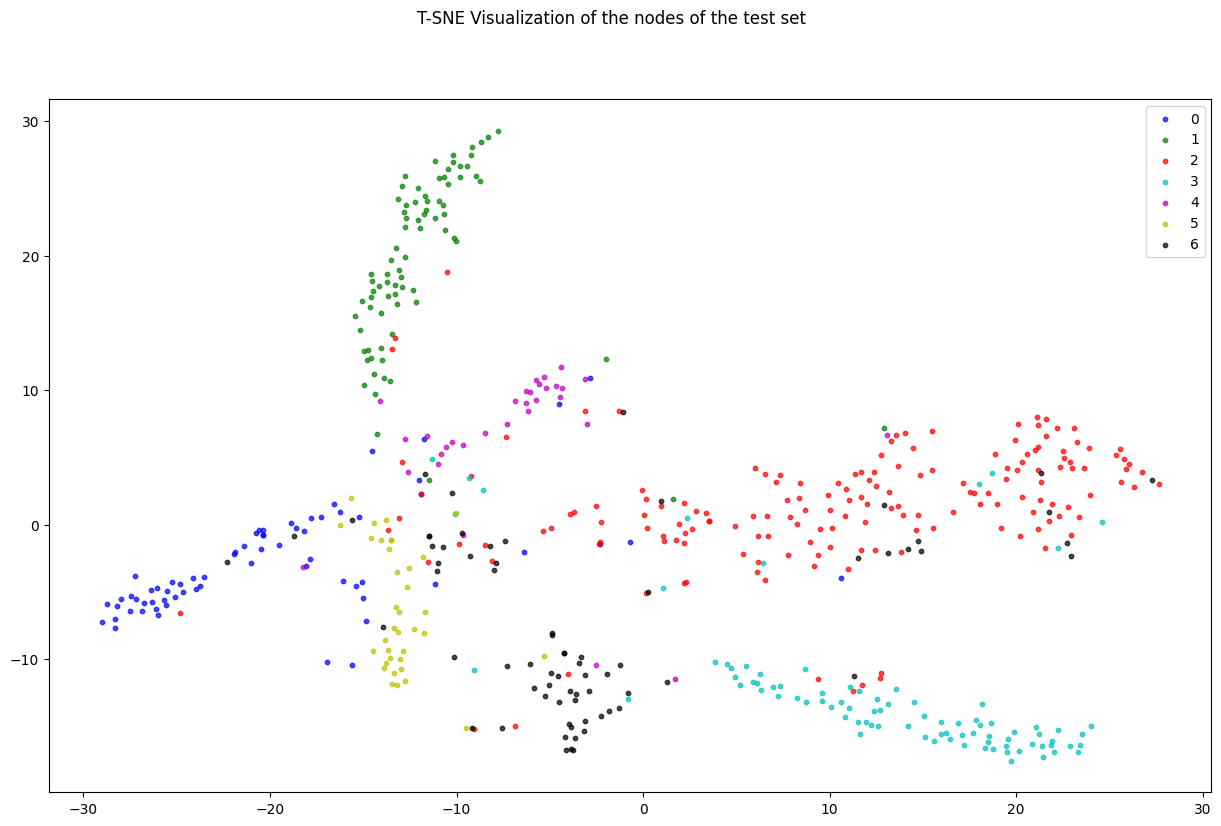

In [22]:


# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 64
n_hidden_2 = 32
learning_rate = 0.01
dropout_rate = 0.5

# Read data
features, adj, class_labels = load_cora()
n = adj.shape[0] # Number of nodes
n_class = np.unique(class_labels).size # Number of classes

adj = normalize_adjacency(adj) # Normalize adjacency matrix

# Yields indices to split data into training, validation and test sets
idx = np.random.permutation(n)
idx_train = idx[:int(0.6*n)]
idx_val = idx[int(0.6*n):int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transform the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(class_labels).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_val = torch.LongTensor(idx_val).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output,_ = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()


    model.eval()
    output,_ = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], y[idx_val])
    acc_val = accuracy_score(torch.argmax(output[idx_val], dim=1).detach().cpu().numpy(), y[idx_val].cpu().numpy())
    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output, embeddings = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())

    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))

    return embeddings[idx_test]


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
embeddings_test = test()



############## Task 13
# Transforms torch tensor to numpy matrix

##################
embeddings_test=embeddings_test.detach().cpu().numpy()
##################


# Projects the emerging representations to two dimensions using t-SNE

##################
embeddings_test_2d = TSNE().fit_transform(embeddings_test)
##################


labels = class_labels[idx_test]
unique_labels = np.unique(labels)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig, ax = plt.subplots()
for i in range(unique_labels.size):
    idxs = [j for j in range(labels.size) if labels[j]==unique_labels[i]]
    ax.scatter(embeddings_test_2d[idxs,0],
               embeddings_test_2d[idxs,1],
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE Visualization of the nodes of the test set',fontsize=12)
fig.set_size_inches(15,9)
plt.show()
